In [1]:
import argparse
import csv
import numpy as np
import os
import pandas as pd
from pprint import pprint
import time
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from util import get_prompt_message, extract_last_integer, extract_last_number
from util import remove_last_sentence

gpt35_df = pd.read_csv('../conditional/data/112_gsm8k_gpt35_cot_onesent_responses.csv')

model_name = "mistralai/Mistral-7B-Instruct-v0.2"
# model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")
model.generation_config = GenerationConfig.from_pretrained(model_name)
model.generation_config.pad_token_id = model.generation_config.eos_token_id

/Users/vivekvajipey/miniconda3/envs/nightly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:21<00:00,  7.31s/it]


In [2]:
row = gpt35_df.iloc[5]
question = row['Question']
from pprint import pprint
pprint(question)

('Mark has a garden with flowers. He planted plants of three different colors '
 'in it. Ten of them are yellow, and there are 80% more of those in purple. '
 'There are only 25% as many green flowers as there are yellow and purple '
 'flowers. How many flowers does Mark have in his garden?')


In [3]:
num_samples = 3
num_fewshot = 0
temp = 0.7
direct_prompt = False

In [4]:
response_outputs = []
unique_answers = {}
messages = get_prompt_message(question, num_fewshot, direct_prompt)
messages

PROMPT:  Q: Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden?
A: Let's think step by step.


[{'role': 'user',
  'content': "Q: Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden?\nA: Let's think step by step."}]

In [5]:
input_1 = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
input_tensor = input_1.repeat(3, 1)
input_1.shape, input_tensor.shape

(torch.Size([1, 86]), torch.Size([3, 86]))

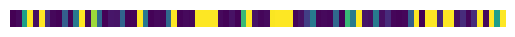

In [6]:
import matplotlib.pyplot as plt
plt.imshow(input_tensor.numpy(), cmap='viridis')
# plt.colorbar()
plt.axis('off')
plt.show()

In [7]:
outputs_1 = model.generate(
                input_1.to(model.device), 
                max_new_tokens=1000, 
                return_dict_in_generate=True, 
                output_scores=True,
                do_sample=True,
                temperature=temp,
                top_k=40,
            )

In [8]:
outputs_1.sequences.shape

torch.Size([1, 249])

In [9]:
"".join([tokenizer.decode(tok.item()) for tok in outputs_1.sequences[:, input_1.shape[1]:][0]])

"Let'sdenotethenumberofpurpleflowersasX.Accordingtotheproblem,thereare80%morepurpleflowersthanyellowones,sothereare1.8*Ten=<b>18</b>purpleflowers.\n\nLet'sdenotethenumberofgreenflowersasG.Theproblemstatesthatthereareonly25%asmanygreenflowersasyellowandpurpleflowerscombined.So,wehave:\n\nG=0.25*(10+18)=0.25*28=<b>7</b>\n\nTherefore,Markhasatotalof<b>10+18+7=35</b>flowersinhisgarden.</s>"

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 100))
plt.imshow(outputs_1.sequences.cpu().numpy(), cmap='viridis')
# plt.colorbar()
plt.axis('off')
plt.show()

In [11]:
outputs = model.generate(
                input_tensor.to(model.device), 
                max_new_tokens=1000, 
                return_dict_in_generate=True, 
                output_scores=True,
                do_sample=True,
                temperature=temp,
                top_k=40,
            )

In [12]:
outputs.sequences.shape

torch.Size([3, 535])

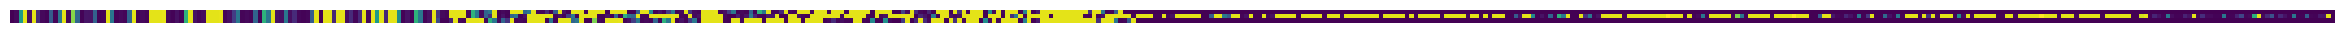

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 100))
plt.imshow(outputs.sequences.cpu().numpy(), cmap='viridis')
plt.axis('off')
plt.show()

In [14]:
tokenizer.batch_decode(outputs.sequences)

["<s> [INST] Q: Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden?\nA: Let's think step by step. [/INST] Let's denote the number of purple flowers as X. Since there are 80% more purple flowers than yellow flowers, and there are 10 yellow flowers, we can write the equation: X = 10 * 1.8 = 18.\n\nLet's denote the number of green flowers as Y. Since there are 25% as many green flowers as there are yellow and purple flowers, we can write: Y = 10 + 10 + 18 * 0.25 = 15.\n\nTherefore, Mark has a total of 10 (yellow) + 18 (purple) + 15 (green) = <<10+18+15=43>>43 flowers in his garden.</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><

In [15]:
outputs = model.generate(
                input_tensor.to(model.device), 
                max_new_tokens=500, 
                return_dict_in_generate=True, 
                output_scores=True,
                do_sample=True,
                temperature=temp,
                top_k=40,
            )

In [16]:
print(outputs.sequences.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 100))
plt.imshow(outputs.sequences.cpu().numpy(), cmap='viridis')
plt.axis('off')
plt.show()

torch.Size([3, 583])


In [17]:
tokenizer.batch_decode(outputs.sequences)

["<s> [INST] Q: Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden?\nA: Let's think step by step. [/INST] Let x be the number of yellow flowers, y be the number of purple flowers, and z be the number of green flowers. We have three equations based on the given information:\n\n1. x + y + z = total number of flowers\n2. x = 10 (the number of yellow flowers)\n3. y = 1.8x (80% more purple flowers than yellow)\n4. z = 0.25x (25% as many green flowers as yellow and purple)\n\nFirst, let's find the number of purple flowers (y). According to equation 3:\n\ny = 1.8 * 10\ny = 18\n\nNow, let's find the number of green flowers (z). According to equation 4:\n\nz = 0.25 * (x + y)\nz = 0.25 * (10 + 18)\nz = 0.25 * 28\nz = 7\n\nNow we have all the flower counts:\n- Yellows: x = 1

In [21]:
tokenizer.encode('.'), tokenizer.encode(". "), tokenizer.encode(" . "), tokenizer.encode(". The")

([1, 842], [1, 842, 28705], [1, 28705, 842, 28705], [1, 842, 415])

In [40]:
tokenizer.decode(842) == tokenizer.decode(28723)

True

In [73]:
tokenizer.encode("\n")

[1, 28705, 13]

In [75]:
tokenizer.decode(13)

'\n'

In [58]:
for tok in tokenizer.encode(" Sentence 1. Sentence 2. Some number 3.5, Sentence 3."):
    print(tok, tokenizer.decode(tok))

1 <s>
28705 
318 S
308 ent
636 ence
28705 
28740 1
28723 .
318 S
308 ent
636 ence
28705 
28750 2
28723 .
2909 Some
1474 number
28705 
28770 3
28723 .
28782 5
28725 ,
318 S
308 ent
636 ence
28705 
28770 3
28723 .


In [81]:
for n in range(10):
    print(n, tokenizer.encode(str(n)))

0 [1, 28705, 28734]
1 [1, 28705, 28740]
2 [1, 28705, 28750]
3 [1, 28705, 28770]
4 [1, 28705, 28781]
5 [1, 28705, 28782]
6 [1, 28705, 28784]
7 [1, 28705, 28787]
8 [1, 28705, 28783]
9 [1, 28705, 28774]


In [82]:
tokenizer.encode("3.5")

[1, 28705, 28770, 28723, 28782]

In [30]:
outputs_1.sequences.flatten()

tensor([    1,   733, 16289, 28793,  1186, 28747,  3655,   659,   264,  8759,
          395, 11888, 28723,   650, 24571,  9923,   302,  1712,  1581,  9304,
          297,   378, 28723, 11819,   302,   706,   460,  9684, 28725,   304,
          736,   460, 28705, 28783, 28734, 28823,   680,   302,  1395,   297,
        19435, 28723,  1387,   460,   865, 28705, 28750, 28782, 28823,   390,
         1287,  5344, 11888,   390,   736,   460,  9684,   304, 19435, 11888,
        28723,  1602,  1287, 11888,  1235,  3655,   506,   297,   516,  8759,
        28804,    13, 28741, 28747,  3169, 28742, 28713,  1073,  3707,   486,
         3707, 28723,   733, 28748, 16289, 28793,  3169, 28742, 28713, 14543,
          272,  1474,   302, 19435, 11888,   390,  1500, 28723,  6586,   298,
          272,  2700, 28725,   736,   460, 28705, 28783, 28734, 28823,   680,
        19435, 11888,   821,  9684,  4413, 28725,   579,   736,   460, 28705,
        28740, 28723, 28783,   398, 11819,   327,   523, 28726, 

In [34]:
# tokenizer.decode(outputs_1.sequences)
# Fix the TypeError by ensuring the input to tokenizer.decode is a list of integers
# decoded_output = tokenizer.decode(outputs_1.sequences.flatten().tolist())
# decoded_output
for token in outputs_1.sequences.flatten():
    decoded_token = tokenizer.decode([token.item()])
    print(f"Token: {token.item()}, Decoded: {decoded_token}")


Token: 1, Decoded: <s>
Token: 733, Decoded: [
Token: 16289, Decoded: INST
Token: 28793, Decoded: ]
Token: 1186, Decoded: Q
Token: 28747, Decoded: :
Token: 3655, Decoded: Mark
Token: 659, Decoded: has
Token: 264, Decoded: a
Token: 8759, Decoded: garden
Token: 395, Decoded: with
Token: 11888, Decoded: flowers
Token: 28723, Decoded: .
Token: 650, Decoded: He
Token: 24571, Decoded: planted
Token: 9923, Decoded: plants
Token: 302, Decoded: of
Token: 1712, Decoded: three
Token: 1581, Decoded: different
Token: 9304, Decoded: colors
Token: 297, Decoded: in
Token: 378, Decoded: it
Token: 28723, Decoded: .
Token: 11819, Decoded: Ten
Token: 302, Decoded: of
Token: 706, Decoded: them
Token: 460, Decoded: are
Token: 9684, Decoded: yellow
Token: 28725, Decoded: ,
Token: 304, Decoded: and
Token: 736, Decoded: there
Token: 460, Decoded: are
Token: 28705, Decoded: 
Token: 28783, Decoded: 8
Token: 28734, Decoded: 0
Token: 28823, Decoded: %
Token: 680, Decoded: more
Token: 302, Decoded: of
Token: 1395, D

In [41]:
outputs_1.sequences.flatten()
# Find the instances of the element 842 in the flattened sequences
indices_of_period = (outputs_1.sequences.flatten() == 28723).nonzero(as_tuple=True)[0]
print("Indices of period token:", indices_of_period)

Indices of period token: tensor([ 12,  22,  41,  60,  81,  97, 121, 136, 150, 172, 184, 199, 247],
       device='mps:0')


In [54]:
tensor_1 = outputs_1.sequences.cpu()

In [55]:
tensor_1.shape

torch.Size([1, 249])

In [60]:
mask = torch.zeros_like(tensor_1)
period_indices = (tensor_1 == 28723).nonzero()
period_indices

tensor([[  0,  12],
        [  0,  22],
        [  0,  41],
        [  0,  60],
        [  0,  81],
        [  0,  97],
        [  0, 121],
        [  0, 136],
        [  0, 150],
        [  0, 172],
        [  0, 184],
        [  0, 199],
        [  0, 247]])

In [77]:
# tok2delim = {28723 : ".", 13 : "\n"}
newline_indices = (tensor_1 == 13).nonzero()
newline_indices

tensor([[  0,  71],
        [  0, 137],
        [  0, 138],
        [  0, 178],
        [  0, 179],
        [  0, 214],
        [  0, 215]])

In [79]:
seq_len = tensor_1.size(1)
seq_len

249

In [80]:
seq_end = (tensor_1 == 2).nonzero()
seq_end

tensor([[  0, 248]])

In [65]:
sentence_start_idx = period_indices[-2] if len(period_indices) > 1 and  else None
sentence_start_idx

tensor([  0, 199])

In [66]:
if sentence_start_idx is not None:
    mask[0, sentence_start_idx[1]+1:] = 1
else:
    mask[0, :] = 1
mask

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [67]:
tensor_1

tensor([[    1,   733, 16289, 28793,  1186, 28747,  3655,   659,   264,  8759,
           395, 11888, 28723,   650, 24571,  9923,   302,  1712,  1581,  9304,
           297,   378, 28723, 11819,   302,   706,   460,  9684, 28725,   304,
           736,   460, 28705, 28783, 28734, 28823,   680,   302,  1395,   297,
         19435, 28723,  1387,   460,   865, 28705, 28750, 28782, 28823,   390,
          1287,  5344, 11888,   390,   736,   460,  9684,   304, 19435, 11888,
         28723,  1602,  1287, 11888,  1235,  3655,   506,   297,   516,  8759,
         28804,    13, 28741, 28747,  3169, 28742, 28713,  1073,  3707,   486,
          3707, 28723,   733, 28748, 16289, 28793,  3169, 28742, 28713, 14543,
           272,  1474,   302, 19435, 11888,   390,  1500, 28723,  6586,   298,
           272,  2700, 28725,   736,   460, 28705, 28783, 28734, 28823,   680,
         19435, 11888,   821,  9684,  4413, 28725,   579,   736,   460, 28705,
         28740, 28723, 28783,   398, 11819,   327,  

In [70]:
ans_tensor = tensor_1 * mask
ans_tensor

tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [72]:
for token in ans_tensor.flatten():
    decoded_token = tokenizer.decode([token.item()])
    print(f"Token: {token.item()}, Decoded: {decoded_token}")

Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>


In [93]:
seq_end[0][1].item()

248

In [98]:
period_indices = (tensor_1 == 28723).nonzero()

digit_tokens = [28734, 28740, 28750, 28770, 28781, 28782, 28784, 28787, 28783, 28774]

# Filter out periods that are part of decimal numbers
filtered_indices = []
for idx in period_indices:
    batch_index, token_index = idx[0], idx[1]
    seq_end = (tensor_1 == 2).nonzero()
    seq_end_index = seq_end[0][1].item()
    # Remove if period is near end of sequence (it is part of last sentence)
    if seq_end_index - token_index < 5:
        print(f"index {token_index} too close to </s> at {seq_end_index}")
    # Check if the period is not at the start or end of the tensor
    elif token_index > 0 and token_index < tensor_1.shape[1] - 1:
        # Check the tokens before and after the period
        token_before = tensor_1[batch_index, token_index - 1]
        token_after = tensor_1[batch_index, token_index + 1]
        # Check if both tokens are numeric
        if not (token_before in digit_tokens and token_after in digit_tokens):
            filtered_indices.append(idx)

# Convert list to tensor
filtered_indices = torch.stack(filtered_indices)

print("Filtered Period Indices:", filtered_indices)

index 247 too close to </s> at 248
Filtered Period Indices: tensor([[  0,  12],
        [  0,  22],
        [  0,  41],
        [  0,  60],
        [  0,  81],
        [  0,  97],
        [  0, 136],
        [  0, 150],
        [  0, 172]])


In [99]:
newline_indices = (tensor_1 == 13).nonzero()
newline_indices

tensor([[  0,  71],
        [  0, 137],
        [  0, 138],
        [  0, 178],
        [  0, 179],
        [  0, 214],
        [  0, 215]])

In [100]:
last_period_index = filtered_indices[-1, 1] if filtered_indices.size(0) > 0 else -1
last_newline_index = newline_indices[-1, 1] if newline_indices.size(0) > 0 else -1

# Determine the maximum index
last_sentence_start_index = max(last_period_index, last_newline_index)

print("Last sentence start index:", last_sentence_start_index)

Last sentence start index: tensor(215)


In [102]:
mask = torch.zeros_like(tensor_1)
if sentence_start_idx is not None:
    mask[0, last_sentence_start_index+1:] = 1
else:
    mask[0, :] = 1
mask

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [103]:
ans_tensor = tensor_1 * mask
for token in ans_tensor.flatten():
    decoded_token = tokenizer.decode([token.item()])
    print(f"Token: {token.item()}, Decoded: {decoded_token}")

Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>
Token: 0, Decoded: <unk>


In [104]:
batch_size, seq_length = tensor_1.shape
digit_tokens = [28734, 28740, 28750, 28770, 28781, 28782, 28784, 28787, 28783, 28774]
mask = torch.zeros_like(tensor_1)

for i in range(batch_size):
    row_tensor = tensor_1[i]

    # Find period indices
    period_indices = (row_tensor == 28723).nonzero()

    # Filter out periods that are part of decimal numbers
    filtered_indices = []
    for idx in period_indices:
        token_index = idx[0]
        seq_end = (row_tensor == 2).nonzero()
        seq_end_index = seq_end[0].item()
        # Remove if period is near end of sequence (it is part of last sentence)
        if seq_end_index - token_index < 5:
            continue
        # Check if the period is not at the start or end of the tensor
        elif token_index > 0 and token_index < seq_length - 1:
            # Check the tokens before and after the period
            token_before = row_tensor[token_index - 1]
            token_after = row_tensor[token_index + 1]
            # Check if both tokens are numeric
            if not (token_before in digit_tokens and token_after in digit_tokens):
                filtered_indices.append(token_index)

    # Find newline indices
    newline_indices = (row_tensor == 13).nonzero()

    # Determine the last sentence start index
    last_period_index = max(filtered_indices) if filtered_indices else -1
    last_newline_index = newline_indices[-1] if newline_indices.size(0) > 0 else -1
    last_sentence_start_index = max(last_period_index, last_newline_index)

    # Set mask for the last sentence
    if last_sentence_start_index != -1:
        mask[i, last_sentence_start_index+1:] = 1

# Apply mask to get only the last sentences
last_sentence_only_tensor = tensor_1 * mask

print("Mask:\n", mask)
print("Last Sentence Only Tensor:\n", last_sentence_only_tensor)

Mask:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])
Last Sentence Only Tensor:
 tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [106]:
for i in range(batch_size):
    row_tensor = last_sentence_only_tensor[i]
    print(row_tensor.shape)
    # decoded_token = tokenizer.decode([token.item()])
    # print(f"Token: {token.item()}, Decoded: {decoded_token}")

torch.Size([249])


In [122]:
def find_last_sentence(tensor):
    batch_size, seq_length = tensor.shape
    digit_tokens = [28734, 28740, 28750, 28770, 28781, 28782, 28784, 28787, 28783, 28774]
    mask = torch.zeros_like(tensor)

    for i in range(batch_size):
        row_tensor = tensor[i]

        period_indices = (row_tensor == 28723).nonzero()

        filtered_indices = []
        for idx in period_indices:
            token_index = idx[0]
            seq_end = (row_tensor == 2).nonzero()
            seq_end_index = seq_end[0].item()
            # Remove if period is near end of sequence (it is part of last sentence)
            if seq_end_index - token_index < 5:
                continue
            # Check if the period is not at the start or end of the tensor
            elif token_index > 0 and token_index < seq_length - 1:
                # Check the tokens before and after the period
                token_before = row_tensor[token_index - 1]
                token_after = row_tensor[token_index + 1]
                # Check if both tokens are numeric
                if not (token_before in digit_tokens and token_after in digit_tokens):
                    filtered_indices.append(token_index)

        newline_indices = (row_tensor == 13).nonzero()

        # Determine the last sentence start index
        last_period_index = max(filtered_indices) if filtered_indices else -1
        last_newline_index = newline_indices[-1] if newline_indices.size(0) > 0 else -1
        last_sentence_start_index = max(last_period_index, last_newline_index)

        # Set mask for the last sentence
        if last_sentence_start_index != -1:
            mask[i, last_sentence_start_index+1:] = 1

    # Apply mask to get only the last sentences
    last_sentence_only_tensor = tensor * mask

    print("Mask:\n", mask)
    print("Last Sentence Only Tensor:\n", last_sentence_only_tensor)
    
    return last_sentence_only_tensor 

In [123]:
lsot = find_last_sentence(outputs.sequences)

Mask:
 tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], device='mps:0')
Last Sentence Only Tensor:
 tensor([[    0,     0,     0,  ...,     2,     2,     2],
        [    0,     0,     0,  ...,     2,     2,     2],
        [    0,     0,     0,  ..., 28734, 28723,     2]], device='mps:0')


In [125]:
plt.figure(figsize=(30, 100))
plt.imshow(outputs.sequences.cpu().numpy(), cmap='viridis')
# plt.colorbar()
plt.axis('off')
plt.show()

In [120]:
plt.figure(figsize=(30, 100))
plt.imshow(lsot.cpu().numpy(), cmap='viridis')
# plt.colorbar()
plt.axis('off')
plt.show()

In [128]:
def print_decoded_tokens(lsot, tokenizer):
    # Iterate over each row in the lsot tensor
    for idx, row_tensor in enumerate(lsot):
        print("ROW ", idx)
        # Flatten the row tensor to iterate over each token
        for token in row_tensor.flatten():
            # Check if the token is not one of the excluded tokens
            if token.item() not in [0, 2, 28734]:
                # Decode the token using the tokenizer
                decoded_token = tokenizer.decode([token.item()])
                # Print the token and its decoded value
                print(f"Token: {token.item()}, Decoded: {decoded_token}")

# Assuming 'outputs.sequences' is your input tensor and 'tokenizer' is your tokenizer instance
lsot = find_last_sentence(outputs.sequences)
print_decoded_tokens(lsot, tokenizer)

Mask:
 tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], device='mps:0')
Last Sentence Only Tensor:
 tensor([[    0,     0,     0,  ...,     2,     2,     2],
        [    0,     0,     0,  ...,     2,     2,     2],
        [    0,     0,     0,  ..., 28734, 28723,     2]], device='mps:0')
ROW  0
Token: 5816, Decoded: There
Token: 994, Decoded: fore
Token: 28725, Decoded: ,
Token: 3655, Decoded: Mark
Token: 659, Decoded: has
Token: 28705, Decoded: 
Token: 28770, Decoded: 3
Token: 28782, Decoded: 5
Token: 11888, Decoded: flowers
Token: 297, Decoded: in
Token: 516, Decoded: his
Token: 8759, Decoded: garden
Token: 28723, Decoded: .
ROW  1
Token: 5142, Decoded: So
Token: 28725, Decoded: ,
Token: 3655, Decoded: Mark
Token: 659, Decoded: has
Token: 28705, Decoded: 
Token: 28770, Decoded: 3
Token: 11888, Decoded: flowers
Token: 297, Decoded: in
Token: 516, Decoded: his
Token: 8759, Decoded: garden
Token: 28723, Decoded: .
ROW  2
Token: 415

In [16]:
def find_last_sentence(tensor):
    batch_size, seq_length = tensor.shape
    digit_tokens = [28734, 28740, 28750, 28770, 28781, 28782, 28784, 28787, 28783, 28774]
    mask = torch.zeros_like(tensor)
    inverse_mask = torch.zeros_like(tensor)

    for i in range(batch_size):
        row_tensor = tensor[i]

        # Find period indices
        period_indices = (row_tensor == 28723).nonzero()

        seq_end = (row_tensor == 2).nonzero()
        seq_end_index = seq_end[0].item()

        # Filter out periods that are part of decimal numbers
        filtered_indices = []
        for idx in period_indices:
            token_index = idx[0]
            # Remove if period is near end of sequence (it is part of last sentence)
            if seq_end_index - token_index < 5:
                continue
            # Check if the period is not at the start or end of the tensor
            elif token_index > 0 and token_index < seq_length - 1:
                # Check the tokens before and after the period
                token_before = row_tensor[token_index - 1]
                token_after = row_tensor[token_index + 1]
                # Check if both tokens are numeric
                if not (token_before in digit_tokens and token_after in digit_tokens):
                    filtered_indices.append(token_index)

        newline_indices = (row_tensor == 13).nonzero()

        # Determine the last sentence start index
        last_period_index = max(filtered_indices) if filtered_indices else -1
        last_newline_index = newline_indices[-1] if newline_indices.size(0) > 0 else -1
        last_sentence_start_index = max(last_period_index, last_newline_index)

        # Set mask for the last sentence
        if last_sentence_start_index != -1:
            mask[i, last_sentence_start_index+1:seq_end_index+1] = 1
            inverse_mask[i, :last_sentence_start_index+1] = 1

    # Apply mask to get only the last sentences
    last_sentence_only_tensor = tensor * mask
    initial_sentences_tensor = tensor * inverse_mask

    print("Mask:\n", mask)
    print("Inverse Mask:\n", inverse_mask)
    print("Last Sentence Only Tensor:\n", last_sentence_only_tensor)
    print("Initial Sentences Tensor:\n", initial_sentences_tensor)
    
    return initial_sentences_tensor, last_sentence_only_tensor 

# ist, lsot = find_last_sentence(outputs.sequences)

In [130]:
print_decoded_tokens(ist, tokenizer)

ROW  0
Token: 1, Decoded: <s>
Token: 733, Decoded: [
Token: 16289, Decoded: INST
Token: 28793, Decoded: ]
Token: 1186, Decoded: Q
Token: 28747, Decoded: :
Token: 3655, Decoded: Mark
Token: 659, Decoded: has
Token: 264, Decoded: a
Token: 8759, Decoded: garden
Token: 395, Decoded: with
Token: 11888, Decoded: flowers
Token: 28723, Decoded: .
Token: 650, Decoded: He
Token: 24571, Decoded: planted
Token: 9923, Decoded: plants
Token: 302, Decoded: of
Token: 1712, Decoded: three
Token: 1581, Decoded: different
Token: 9304, Decoded: colors
Token: 297, Decoded: in
Token: 378, Decoded: it
Token: 28723, Decoded: .
Token: 11819, Decoded: Ten
Token: 302, Decoded: of
Token: 706, Decoded: them
Token: 460, Decoded: are
Token: 9684, Decoded: yellow
Token: 28725, Decoded: ,
Token: 304, Decoded: and
Token: 736, Decoded: there
Token: 460, Decoded: are
Token: 28705, Decoded: 
Token: 28783, Decoded: 8
Token: 28823, Decoded: %
Token: 680, Decoded: more
Token: 302, Decoded: of
Token: 1395, Decoded: those
Toke

In [131]:
print_decoded_tokens(lsot, tokenizer)

ROW  0
Token: 5816, Decoded: There
Token: 994, Decoded: fore
Token: 28725, Decoded: ,
Token: 3655, Decoded: Mark
Token: 659, Decoded: has
Token: 28705, Decoded: 
Token: 28770, Decoded: 3
Token: 28782, Decoded: 5
Token: 11888, Decoded: flowers
Token: 297, Decoded: in
Token: 516, Decoded: his
Token: 8759, Decoded: garden
Token: 28723, Decoded: .
ROW  1
Token: 5142, Decoded: So
Token: 28725, Decoded: ,
Token: 3655, Decoded: Mark
Token: 659, Decoded: has
Token: 28705, Decoded: 
Token: 28770, Decoded: 3
Token: 11888, Decoded: flowers
Token: 297, Decoded: in
Token: 516, Decoded: his
Token: 8759, Decoded: garden
Token: 28723, Decoded: .
ROW  2
Token: 415, Decoded: The
Token: 3102, Decoded: total
Token: 1474, Decoded: number
Token: 302, Decoded: of
Token: 11888, Decoded: flowers
Token: 349, Decoded: is
Token: 1401, Decoded: around
Token: 28705, Decoded: 
Token: 28740, Decoded: 1
Token: 28770, Decoded: 3
Token: 28723, Decoded: .


In [135]:
pprint(tokenizer.decode(outputs.sequences[0]))

('<s> [INST] Q: Mark has a garden with flowers. He planted plants of three '
 'different colors in it. Ten of them are yellow, and there are 80% more of '
 'those in purple. There are only 25% as many green flowers as there are '
 'yellow and purple flowers. How many flowers does Mark have in his garden?\n'
 "A: Let's think step by step. [/INST] Let x be the number of yellow flowers, "
 'y be the number of purple flowers, and z be the number of green flowers. We '
 'have three equations based on the given information:\n'
 '\n'
 '1. x + y + z = total number of flowers\n'
 '2. x = 10 (the number of yellow flowers)\n'
 '3. y = 1.8x (80% more purple flowers than yellow)\n'
 '4. z = 0.25x (25% as many green flowers as yellow and purple)\n'
 '\n'
 "First, let's find the number of purple flowers (y). According to equation "
 '3:\n'
 '\n'
 'y = 1.8 * 10\n'
 'y = 18\n'
 '\n'
 "Now, let's find the number of green flowers (z). According to equation 4:\n"
 '\n'
 'z = 0.25 * (x + y)\n'
 'z = 0.25 *

In [138]:
pprint(tokenizer.decode(ist[2]))

('<s> [INST] Q: Mark has a garden with flowers. He planted plants of three '
 'different colors in it. Ten of them are yellow, and there are 80% more of '
 'those in purple. There are only 25% as many green flowers as there are '
 'yellow and purple flowers. How many flowers does Mark have in his garden?\n'
 "A: Let's think step by step. [/INST] Let's denote the number of purple "
 'flowers as X. We know that there are 80% more purple flowers than yellow '
 'ones, so the number of yellow flowers is X/1.8 (since 80% is equivalent to '
 '0.8 or 1/1.8). We also know that there are 25% as many green flowers as '
 "there are yellow and purple flowers combined. Let's denote the number of "
 'green flowers as G.\n'
 '\n'
 "First, let's find the total number of yellow and purple flowers:\n"
 'Total yellow and purple flowers = X + X/1.8\n'
 '\n'
 "Now, let's find the number of green flowers:\n"
 'Green flowers = 0.25 * (X + X/1.8)\n'
 '\n'
 'Since we know that Mark has ten yellow flowers, we ca

In [139]:
pprint(tokenizer.decode(lsot[2]))

('<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><un

Frankensteining

In [160]:
def append_last_sentence_of_first_row(ist, lsot, lsot_index):
    # Extract the last sentence from the first row of lsot
    last_sentence_first_row = lsot[lsot_index]
    # Filter out zeros (masked tokens)
    last_sentence_first_row = last_sentence_first_row[last_sentence_first_row != 0]
    last_sentence_first_row = last_sentence_first_row[last_sentence_first_row != 2]
    last_sentence_first_row = torch.cat((last_sentence_first_row, torch.tensor([2]).to(last_sentence_first_row.device)))
    print("lsfr", last_sentence_first_row)

    # Determine the maximum possible length of the new rows
    max_length = ist.size(1) + last_sentence_first_row.size(0)

    # Create a new tensor to hold the result with the expanded size
    new_tensor = torch.zeros((ist.size(0), max_length), dtype=ist.dtype)

    for i in range(ist.size(0)):
        # Get the initial sentence tokens from ist for the current row
        initial_sentence = ist[i]
        initial_sentence = initial_sentence[initial_sentence != 0]

        # Concatenate the initial sentence with the last sentence of the first row
        combined_sentence = torch.cat((initial_sentence, last_sentence_first_row))

        # Place the combined sentence into the new tensor, respecting the original row index
        new_tensor[i, :combined_sentence.size(0)] = combined_sentence

    return new_tensor

In [27]:
import torch

def append_last_sentence_of_first_row_with_mask(ist, lsot):
    # Extract the last sentence from the first row of lsot
    last_sentence_first_row = lsot[0]
    # Filter out zeros (masked tokens)
    last_sentence_first_row = last_sentence_first_row[last_sentence_first_row != 0]

    # Determine the maximum possible length of the new rows
    max_length = ist.size(1) + last_sentence_first_row.size(0)

    # Create a new tensor to hold the result with the expanded size
    new_tensor = torch.zeros((ist.size(0), max_length), dtype=ist.dtype)
    new_mask = torch.zeros((ist.size(0), max_length), dtype=torch.uint8)

    for i in range(ist.size(0)):
        # Get the initial sentence tokens from ist for the current row
        initial_sentence = ist[i]
        initial_sentence = initial_sentence[initial_sentence != 0]

        # Concatenate the initial sentence with the last sentence of the first row
        combined_sentence = torch.cat((initial_sentence, last_sentence_first_row))

        # Place the combined sentence into the new tensor, respecting the original row index
        new_tensor[i, :combined_sentence.size(0)] = combined_sentence

        # Create mask for the appended last sentence
        start_index_of_last_sentence = initial_sentence.size(0)
        end_index_of_last_sentence = start_index_of_last_sentence + last_sentence_first_row.size(0)
        new_mask[i, start_index_of_last_sentence:end_index_of_last_sentence] = 1

    return new_tensor, new_mask

In [161]:
new_tensor = append_last_sentence_of_first_row(ist, lsot, 0)
print(new_tensor)

lsfr tensor([ 5816,   994, 28725,  3655,   659, 28705, 28770, 28782, 11888,   297,
          516,  8759, 28723,     2], device='mps:0')
tensor([[    1,   733, 16289,  ...,     0,     0,     0],
        [    1,   733, 16289,  ...,     0,     0,     0],
        [    1,   733, 16289,  ...,     0,     0,     0]])


In [162]:
pprint(tokenizer.decode(new_tensor[2]))

('<s> [INST] Q: Mark has a garden with flowers. He planted plants of three '
 'different colors in it. Ten of them are yellow, and there are 80% more of '
 'those in purple. There are only 25% as many green flowers as there are '
 'yellow and purple flowers. How many flowers does Mark have in his garden?\n'
 "A: Let's think step by step. [/INST] Let's denote the number of purple "
 'flowers as X. We know that there are 80% more purple flowers than yellow '
 'ones, so the number of yellow flowers is X/1.8 (since 80% is equivalent to '
 '0.8 or 1/1.8). We also know that there are 25% as many green flowers as '
 "there are yellow and purple flowers combined. Let's denote the number of "
 'green flowers as G.\n'
 '\n'
 "First, let's find the total number of yellow and purple flowers:\n"
 'Total yellow and purple flowers = X + X/1.8\n'
 '\n'
 "Now, let's find the number of green flowers:\n"
 'Green flowers = 0.25 * (X + X/1.8)\n'
 '\n'
 'Since we know that Mark has ten yellow flowers, we ca

In [163]:
new_tensor = append_last_sentence_of_first_row(ist, lsot, 2)
print(new_tensor)

lsfr tensor([  415,  3102,  1474,   302, 11888,   349,  1401, 28705, 28740, 28770,
        28734, 28723,     2], device='mps:0')
tensor([[    1,   733, 16289,  ...,     0,     0,     0],
        [    1,   733, 16289,  ...,     0,     0,     0],
        [    1,   733, 16289,  ...,     0,     0,     0]])


In [166]:
pprint(tokenizer.decode(new_tensor[0]))

('<s> [INST] Q: Mark has a garden with flowers. He planted plants of three '
 'different colors in it. Ten of them are yellow, and there are 80% more of '
 'those in purple. There are only 25% as many green flowers as there are '
 'yellow and purple flowers. How many flowers does Mark have in his garden?\n'
 "A: Let's think step by step. [/INST] Let x be the number of yellow flowers, "
 'y be the number of purple flowers, and z be the number of green flowers. We '
 'have three equations based on the given information:\n'
 '\n'
 '1. x + y + z = total number of flowers\n'
 '2. x = 10 (the number of yellow flowers)\n'
 '3. y = 1.8x (80% more purple flowers than yellow)\n'
 '4. z = 0.25x (25% as many green flowers as yellow and purple)\n'
 '\n'
 "First, let's find the number of purple flowers (y). According to equation "
 '3:\n'
 '\n'
 'y = 1.8 * 10\n'
 'y = 18\n'
 '\n'
 "Now, let's find the number of green flowers (z). According to equation 4:\n"
 '\n'
 'z = 0.25 * (x + y)\n'
 'z = 0.25 *

In [167]:
torch.save(outputs.sequences, 'tensors/flowers_3_ans_test.pt')
print("Tensor saved successfully.")

Tensor saved successfully.


Running on Base Model

In [1]:
import argparse
import csv
import numpy as np
import os
import pandas as pd
from pprint import pprint
import time
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from util import get_prompt_message, extract_last_integer, extract_last_number
from util import remove_last_sentence
from gsm8k_distributions import find_last_sentence, append_last_sentence_of_first_row_with_mask

gpt35_df = pd.read_csv('../conditional/data/112_gsm8k_gpt35_cot_onesent_responses.csv')

/Users/vivekvajipey/miniconda3/envs/nightly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model_name = "mistralai/Mistral-7B-v0.1"
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_tokenizer.pad_token = base_tokenizer.eos_token
base_model = AutoModelForCausalLM.from_pretrained(base_model_name, torch_dtype=torch.bfloat16, device_map="auto")
base_model.generation_config = GenerationConfig.from_pretrained(base_model_name)
base_model.generation_config.pad_token_id =base_model.generation_config.eos_token_id

Loading checkpoint shards: 100%|██████████| 2/2 [00:22<00:00, 11.46s/it]


In [3]:
gen_outputs = torch.load('tensors/flowers_3_ans_test.pt')
print("Loaded tensor:", gen_outputs)

Loaded tensor: tensor([[    1,   733, 16289,  ...,     2,     2,     2],
        [    1,   733, 16289,  ...,     2,     2,     2],
        [    1,   733, 16289,  ..., 28734, 28723,     2]], device='mps:0')


In [4]:
ist, lsot = find_last_sentence(gen_outputs)

Mask:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]], device='mps:0')
Inverse Mask:
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='mps:0')
Last Sentence Only Tensor:
 tensor([[    0,     0,     0,  ...,     0,     0,     0],
        [    0,     0,     0,  ...,     0,     0,     0],
        [    0,     0,     0,  ..., 28734, 28723,     2]], device='mps:0')
Initial Sentences Tensor:
 tensor([[    1,   733, 16289,  ...,     0,     0,     0],
        [    1,   733, 16289,  ...,     0,     0,     0],
        [    1,   733, 16289,  ...,     0,     0,     0]], device='mps:0')


In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 100))
plt.imshow(lsot.cpu().numpy(), cmap='viridis')
# plt.colorbar()
plt.axis('off')
plt.show()

In [6]:
new_tensor, new_mask = append_last_sentence_of_first_row_with_mask(ist, lsot)
print("New Tensor:\n", new_tensor)
print("New Mask:\n", new_mask)

New Tensor:
 tensor([[    1,   733, 16289,  ...,     0,     0,     0],
        [    1,   733, 16289,  ...,     0,     0,     0],
        [    1,   733, 16289,  ...,     0,     0,     0]])
New Mask:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)


In [7]:
new_tensor.shape

torch.Size([3, 597])

In [8]:
plt.figure(figsize=(30, 100))
plt.imshow(new_tensor.cpu().numpy(), cmap='viridis')
plt.axis('off')
plt.show()

In [9]:
plt.figure(figsize=(30, 100))
plt.imshow(new_mask.cpu().numpy(), cmap='viridis')
plt.axis('off')
plt.show()

In [15]:
def to_tokens_and_logprobs(model, tokenizer, input_ids, answer_mask, print_logging=False):
    input_ids = input_ids.to(model.device)
    answer_mask = answer_mask.to(model.device)

    outputs = model(input_ids)
    if print_logging:
        print("outputs logits: ", outputs.logits.shape)

    probs = torch.log_softmax(outputs.logits, dim=-1).detach()

    # Adjust indices to ignore the first token's log prob as it corresponds to the second token
    probs = probs[:, :-1, :]
    input_ids = input_ids[:, 1:]

    gen_probs = torch.gather(probs, 2, input_ids[:, :, None]).squeeze(-1)

    masked_probs = gen_probs * answer_mask[:, 1:].float()  # Ensure the mask is aligned and of the correct type
    if print_logging:
        print("masked_probs: ", masked_probs.shape)

    summed_probs = masked_probs.sum(dim=1)
    if print_logging:
        print("summed_probs: ", summed_probs.shape)

        batch = []
        for input_sentence, input_probs in zip(input_ids, masked_probs):
            text_sequence = []
            for token, p in zip(input_sentence, input_probs):
                if token not in tokenizer.all_special_ids:
                    print((tokenizer.decode(token), p.item()))
                    text_sequence.append((tokenizer.decode(token), p.item()))
            batch.append(text_sequence)

    return summed_probs

In [16]:
summed_probs = to_tokens_and_logprobs(base_model, base_tokenizer, new_tensor, new_mask)

In [17]:
summed_probs

tensor([ -2.4279, -15.7756, -22.9401], device='mps:0')

In [20]:
(summed_probs / 3).sum()

tensor(-13.7145, device='mps:0')

In [21]:
summed_probs.sum() / 3

tensor(-13.7145, device='mps:0')